In [15]:
import matplotlib.pyplot as plt
import schwimmbad
import dynesty.plotting as dyplot
import dynesty.results as dyres
import dynesty.utils as dyfunc
import dynesty
import pickle
import corner
import numpy as np
import numpy
import time
import sys
import os

In [16]:
def line_model(p, x):
    m, b, lnf = p

    return m * x + b

def loglike(p, x, y, yerr):
    m, b, lnf = p 

    model = line_model(p, x)

    inv_sigma2 = 1./(yerr**2 + model**2*np.exp(2*lnf))

    return -0.5 * np.sum((y - model)**2 * inv_sigma2 - np.log(inv_sigma2))

def ptform(u):
    p = np.array(u)

    p[0] = 10.*u[0] - 5.
    p[1] = 10.*u[1]
    p[2] = 11.*u[2] - 10.

    return p

def plot_status(res):
    # Generate a plot of the trace.

    try:
        fig, ax = dyplot.traceplot(res, truths=[m_true, b_true, \
                np.log(f_true)], truth_color="black", show_titles=True, \
                trace_cmap='viridis', connect=True, \
                connect_highlight=range(5))
    except:
        fig, ax = dyplot.traceplot(res, truths=[m_true, b_true, \
                np.log(f_true)], truth_color="black", show_titles=True, \
                trace_cmap='viridis')

    plt.show(fig)

    # Generate a bounds cornerplot.

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    dyplot.cornerbound(res, it=res.niter-1, prior_transform=ptform, \
            show_live=True, fig=(fig, ax))

    plt.show(fig)

In [17]:
pool=None

In [18]:
numpy.random.seed(42)

m_true = -0.9594
b_true = 4.294
f_true = 0.534

N = 50

x = numpy.sort(10*numpy.random.rand(N))
yerr = 0.1+0.5*numpy.random.randn(N)
y = m_true * x + b_true

y += numpy.abs(f_true*y) * numpy.random.randn(N)
y += yerr * numpy.random.randn(N)


In [19]:
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=1000, \
            bound='single', logl_args=(x, y, yerr), pool=pool)


In [20]:
sampler.run_nested()
results = sampler.results

iter: 10650 | bound: 18 | nc: 3 | ncall: 62541 | eff(%): 17.029 | loglstar:   -inf < -33.719 <    inf | logz: -44.360 +/-  0.137 | dlogz:  2.280 >  1.009                                             IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iter: 11576 | +1000 | bound: 20 | nc: 1 | ncall: 64629 | eff(%): 19.459 | loglstar:   -inf < -31.535 <    inf | logz: -43.026 +/-  0.159 | dlogz:  0.001 >  1.009                                     

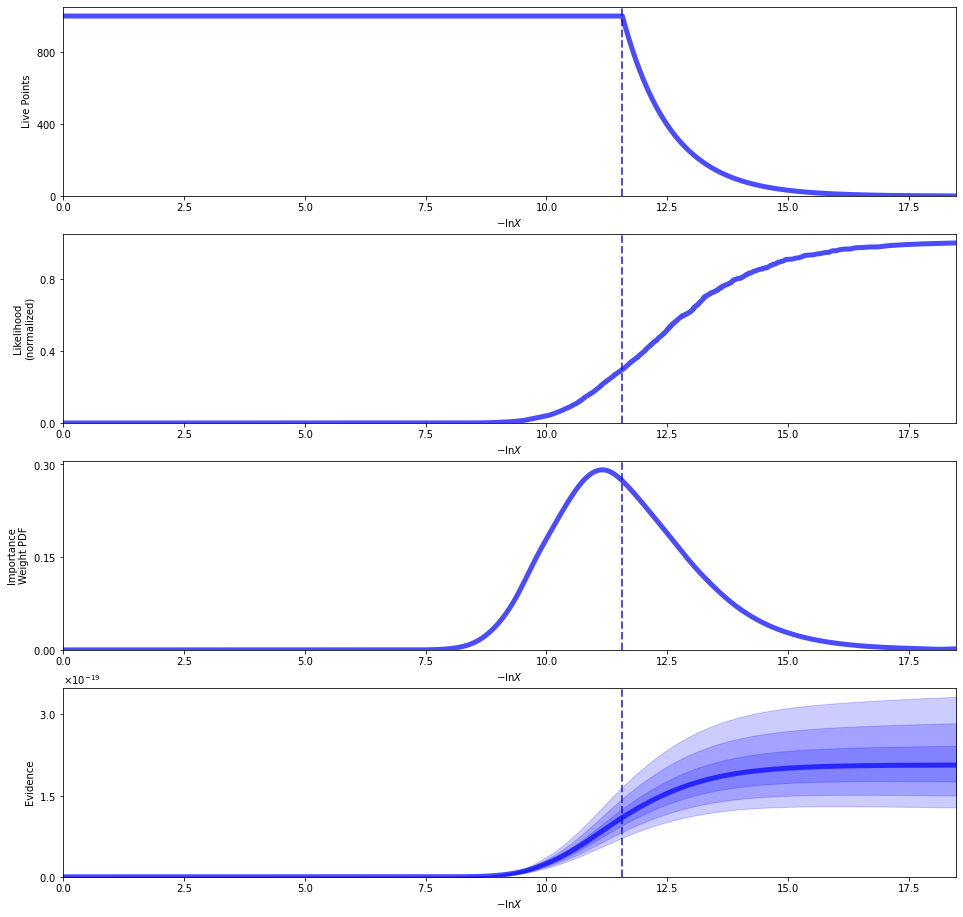

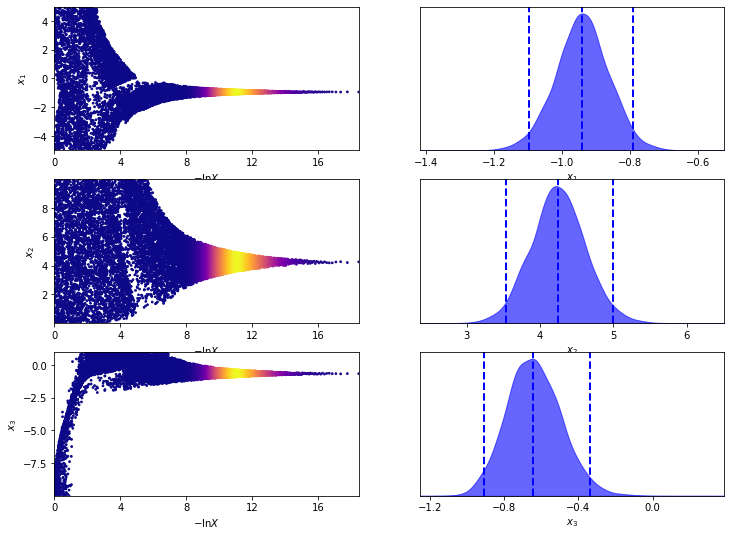

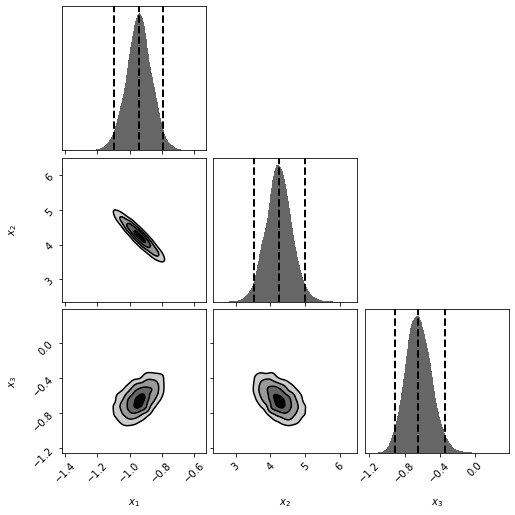

In [21]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

iter: 5000 | +1000 | bound: 5 | nc: 1 | ncall: 42173 | eff(%): 14.227 | loglstar:   -inf < -31.743 <    inf | logz: -42.842 +/-  0.588 | dlogz:  0.369 >  0.010                                       

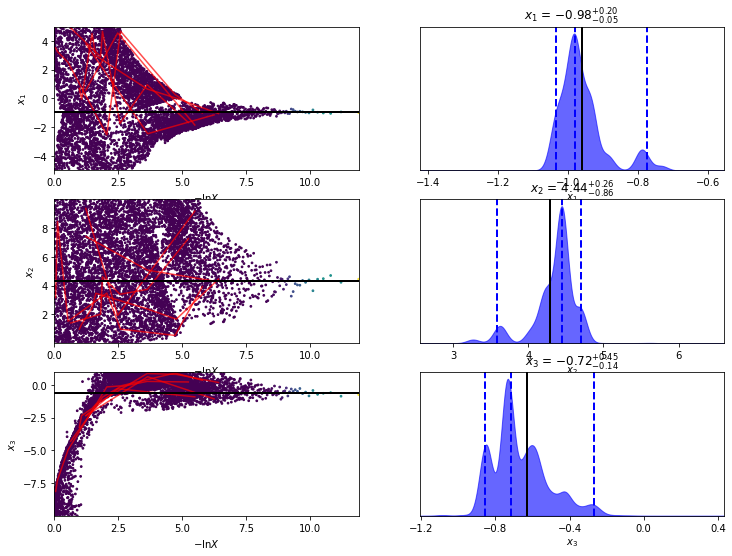

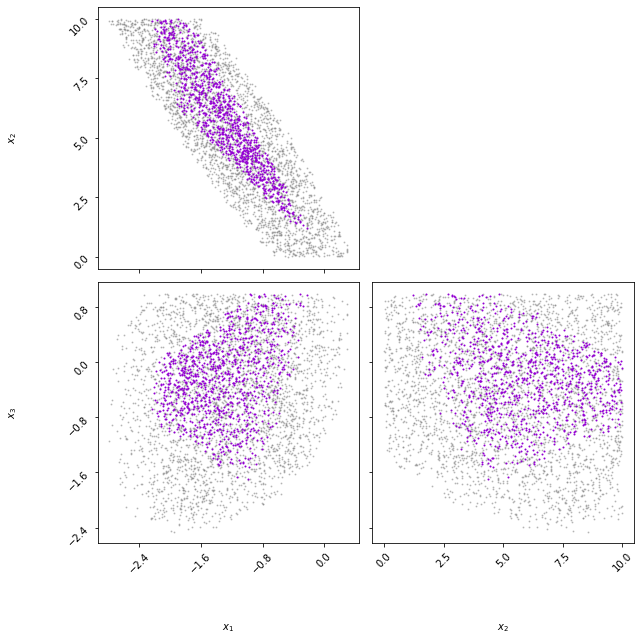

iter: 10000 | +1000 | bound: 16 | nc: 1 | ncall: 59463 | eff(%): 18.499 | loglstar:   -inf < -31.544 <    inf | logz: -43.210 +/-  0.220 | dlogz:  0.005 >  0.010                                     

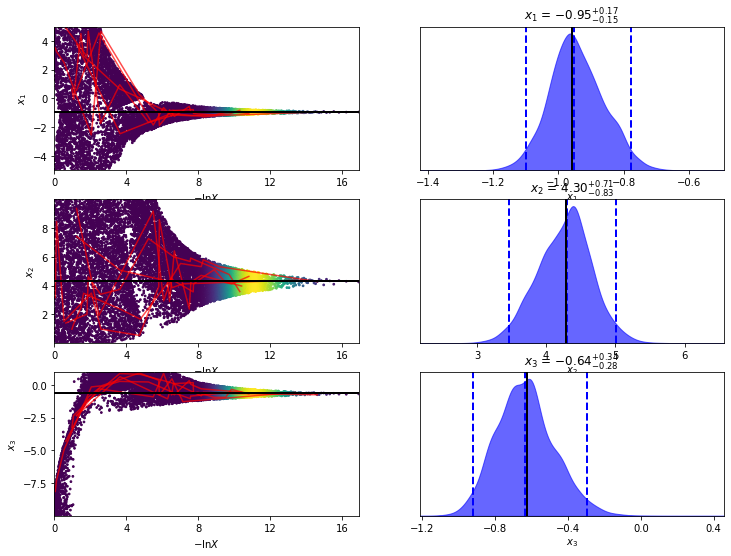

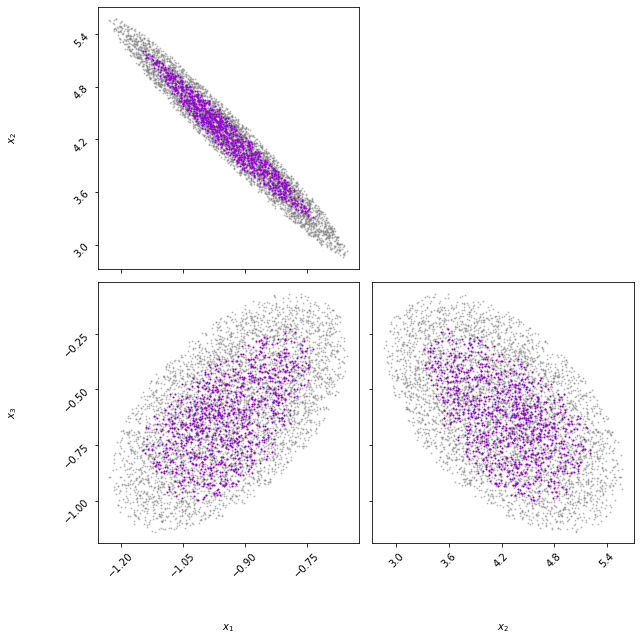

iter: 14656 | +1000 | bound: 24 | nc: 1 | ncall: 70229 | eff(%): 22.293 | loglstar:   -inf < -31.534 <    inf | logz: -43.167 +/-  0.142 | dlogz:  0.000 >  0.010                                     

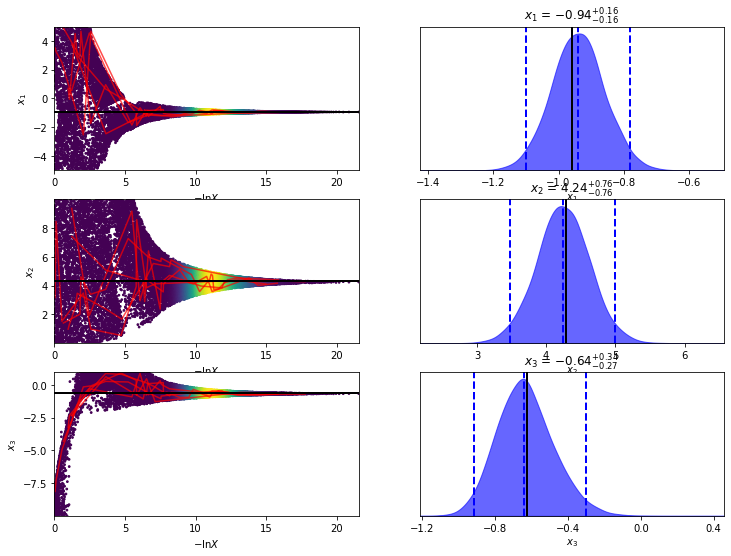

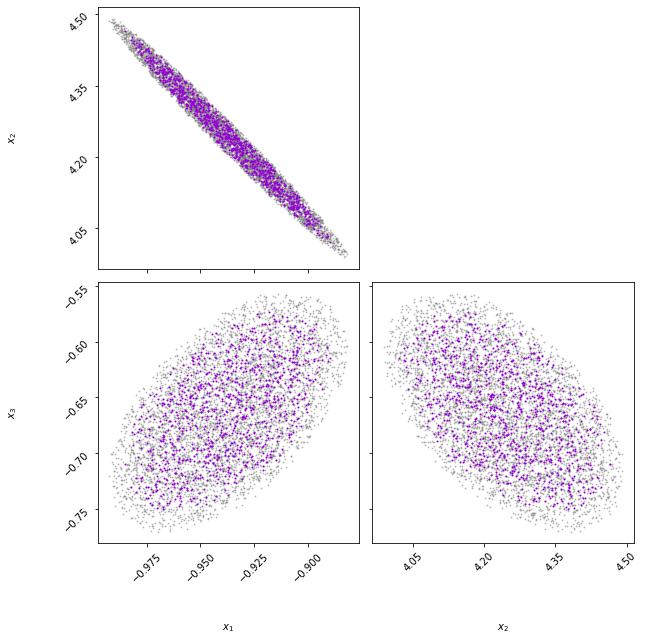

In [11]:
dlogz = 0.05

for it, results in enumerate(sampler.sample(dlogz=dlogz)):
    # Print out the status of the sampler.

    dyres.print_fn(results, sampler.it - 1, sampler.ncall, dlogz=dlogz, \
            logl_max=numpy.inf)

    # Manually calculate the stopping criterion.

    logz_remain = numpy.max(sampler.live_logl) + sampler.saved_logvol[-1]
    delta_logz = numpy.logaddexp(sampler.saved_logz[-1], logz_remain) - \
            sampler.saved_logz[-1]

    # Every 5000 steps stop and make plots of the status.

    if (sampler.it - 1) % 5000 == 0 or delta_logz < dlogz:
        # Save the current state of the sampler.

        sampler.rstate = None
        sampler.pool = None
        sampler.M = map

        pickle.dump(sampler, open("nestedsampler.p", "wb"))

        sampler.rstate = numpy.random
        sampler.pool = pool
        if pool != None:
            sampler.M = pool.map
        else:
            sampler.M = map

        # Add the live points and get the results.

        sampler.add_final_live()

        res = sampler.results

        # Make plots of the current status of the fit.

        plot_status(res)

        # If we haven't reached the stopping criteria yet, remove the live \
        # points.

        if delta_logz >= dlogz:
            sampler._remove_live_points()


In [ ]:
# Check whether the live points were added (useful if the sampling is done and 
# we are just resuming to plot.

if not sampler.added_live:
    sampler.add_final_live()

    # Gather the results and make one final plot of the status.

    res = sampler.results

    plot_status(res)

In [14]:
print(pool)

None


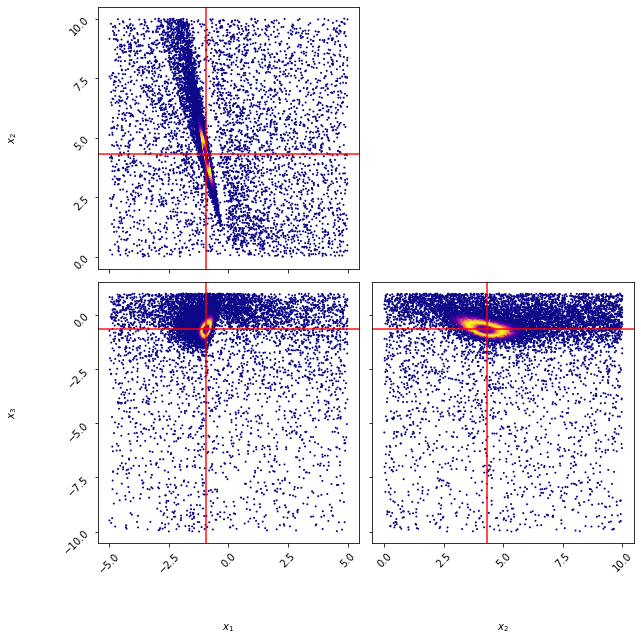

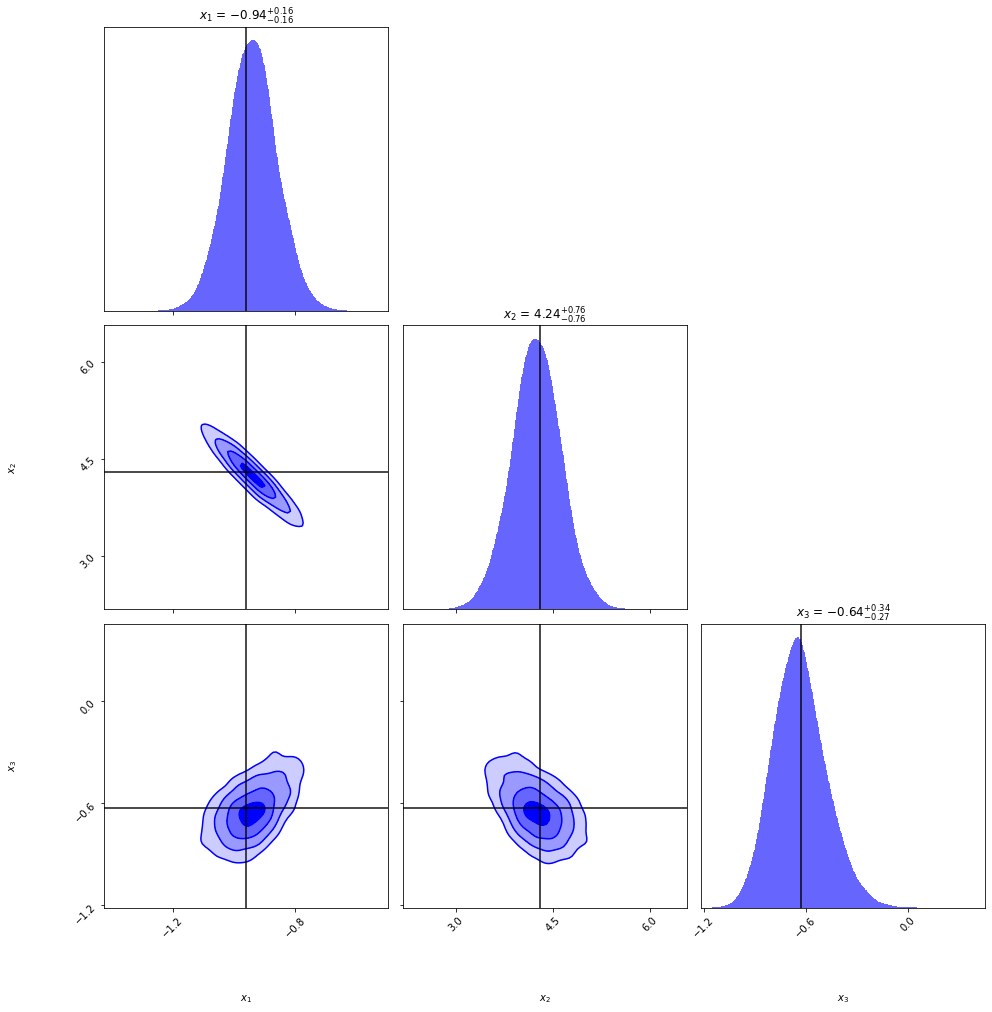

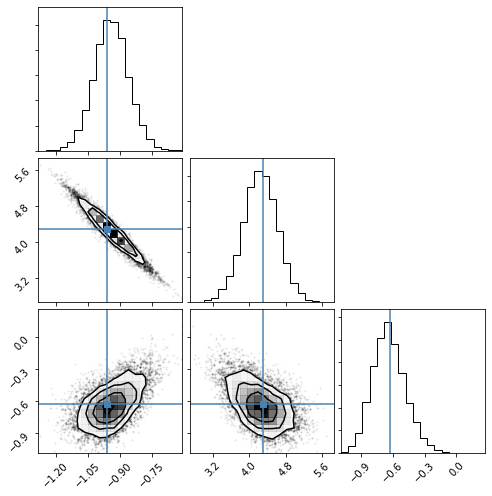

In [12]:
# Generate a plot of the weighted samples.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

dyplot.cornerpoints(res, cmap='plasma', truths=[m_true, b_true, \
        numpy.log(f_true)], kde=False, fig=(fig, ax))

plt.show(fig)

# Generate a corner plot.

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

dyplot.cornerplot(res, color='blue', truths=[m_true, b_true, \
        numpy.log(f_true)], truth_color="black", show_titles=True, \
        max_n_ticks=3, quantiles=None, fig=(fig, ax))

plt.show(fig)

# Generate a corner plot with the old corner program.

samples, weights = res.samples, numpy.exp(res.logwt - res.logz[-1])

new_samples = dyfunc.resample_equal(samples, weights)

fig = corner.corner(new_samples, truths=[m_true, b_true, numpy.log(f_true)])

plt.show(fig)